In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

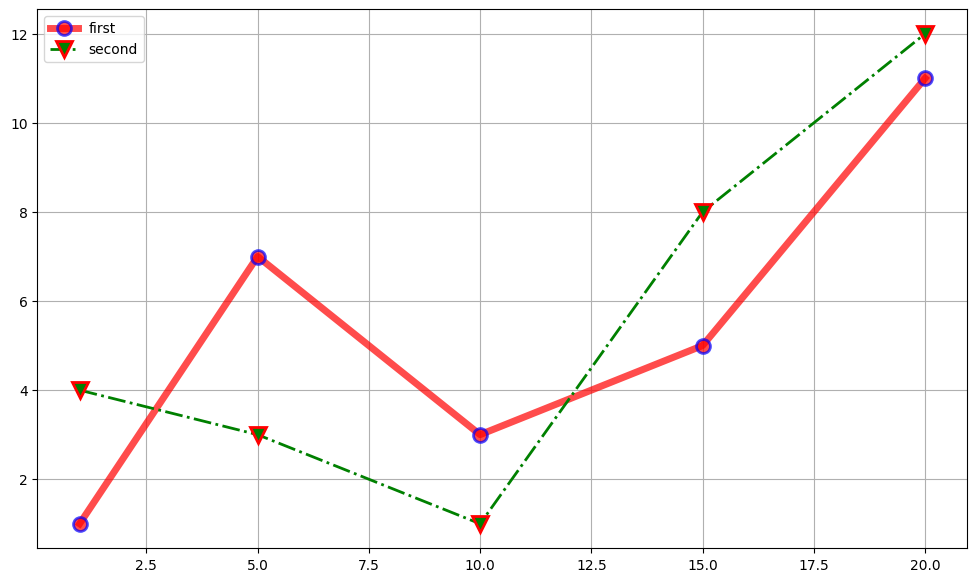

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m, EfficientNet_V2_S_Weights, efficientnet_v2_s
import numpy as np
import shutil
from collections import defaultdict
from functools import partial
from itertools import chain
import os
import json
import typing
from typing import Optional
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import defaultdict
from accelerate import Accelerator
from PIL import Image
import re

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

os.environ["TOKENIZERS_PARALLELISM"] = "true"

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    import random
    import numpy as np
    import torch
    
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def visualise_pics(dataset, indexes):
    items = [dataset[index] for index in indexes]
    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, (image, _) in enumerate(items):
        ax.ravel()[i].imshow(image.numpy().transpose([1, 2, 0]))
        ax.ravel()[i].set_axis_off()
    plt.show()

def visualise_1pic(img: torch.Tensor) -> None:
    plt.imshow(torch.einsum("chw->hwc", img))
    plt.plot()

In [6]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               level : int = 1,
               category1: str = None,
               category2: str = None,
               category3: str = None,
               category4: str = None,
               ):

    folders = os.listdir(data_dir)
    
    if level not in range(1,6):
        raise ValueError("The value of 'level' must be 1, 2, 3, 4 or 5")
    
    if level == 1:
        categories = folders

    elif level == 2:
        if category1 is None:
            raise TypeError("choose_category() missing 1 required positional argument: 'category1'")
        categories = [category for category in folders if category.split("_")[0]==category1]

    elif level == 3:
        if category1 is None or category2 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1' or 'category2'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2)]

    elif level == 4:
        if category1 is None or category2 is None or category3 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2' or 'category3'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3)]

    elif level == 5:
        if category1 is None or category2 is None or category3 is None  or category4 is None:
            raise TypeError("choose_category() missing required positional argument: 'category1', 'category2', 'category3' or 'category4'")
        categories = [category for category in folders if (category.split("_")[0]==category1) and (category.split("_")[1]==category2) and (category.split("_")[2]==category3) and (category.split("_")[3]==category4)]
    
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = [path.parts[-3:-2][0] for path in img_paths]
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(img_paths : list[Path],
                       target_enc : list,
                       SEED : int,
                       ):
    
    train_paths, test_paths, ytrain, ytest = train_test_split(img_paths, target_enc,
                                                              test_size=0.2,
                                                              stratify=target_enc,
                                                              random_state=SEED)
    return train_paths, test_paths, ytrain, ytest

In [7]:
def text_prepocessing(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text


def get_descriptions(paths: list[Path]):
    descriptions = []
    
    for path in paths:
        line = pd.read_csv(path.parents[1] / "descriptions.csv", index_col="item").loc[path.name]
        descriptions.append(line)
        
    df = pd.DataFrame(descriptions)
    df['descriptions_preproc'] = df.description.apply(text_prepocessing)
    return df


def get_tokenizer(df_descriptions, saving : bool = False):
    tokenizer = Tokenizer(BPE())
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=["[PAD]", "[MASK]"])

    # обучение
    tokenizer.train_from_iterator(df_descriptions["descriptions_preproc"], trainer=trainer)
    
    if saving:
        # сохранили в файл
        tokenizer.save("tokenizer.json") 
    
    return tokenizer

In [8]:
data_dir = Path("C:/temp/!hse-mlds-project-year2") / "data/data"
processor = MobileNet_V2_Weights.IMAGENET1K_V2.transforms(
    antialias=True,
)

# в данной функции определяется надо ли исп-ть feedbacks и какие категории брать
img_paths, target_enc, _, idx2target = get_target(data_dir,
                                                  feedbacks=False,
                                                  level=3,
                                                  category1="Канцтовары",
                                                  category2="Бумажная&продукция")
train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

In [9]:
descriptions_train = get_descriptions(train_paths)
descriptions_test = get_descriptions(test_paths)

tokenizer = get_tokenizer(descriptions_train)
print(tokenizer.get_vocab_size())                       # посмотрим на размер словаря

descriptions_train

11329


,description,descriptions_preproc
17.png,Классный журнал для 5-9 классов.Соответствует ...,классный журнал для 5 9 классов соответствует ...
0.png,Ежедневник с ручкой - лучший подарок для успеш...,ежедневник с ручкой лучший подарок для успешно...
2.png,"Стикеры для заметок прозрачные 100 штук 9,6 см...",стикеры для заметок прозрачные 100 штук 9 6 см...
19.png,Универсальный мини блокнот на скобах beSmart и...,универсальный мини блокнот на скобах besmart и...
11.png,Диплом выпускника детского сада выполнен в тве...,диплом выпускника детского сада выполнен в тве...
...,...,...
11.png,Универсальный блокнот на скобах beSmart в стил...,универсальный блокнот на скобах besmart в стил...
9.png,Дневник школьный для мальчика 1-4класс в тверд...,дневник школьный для мальчика 1 4класс в тверд...
13.png,Медицинская карта для ребенка (форма №026/у) я...,медицинская карта для ребенка форма 026 у явля...
12.png,"Самоклеющиеся прозрачные стикеры, также извест...",самоклеющиеся прозрачные стикеры также известн...


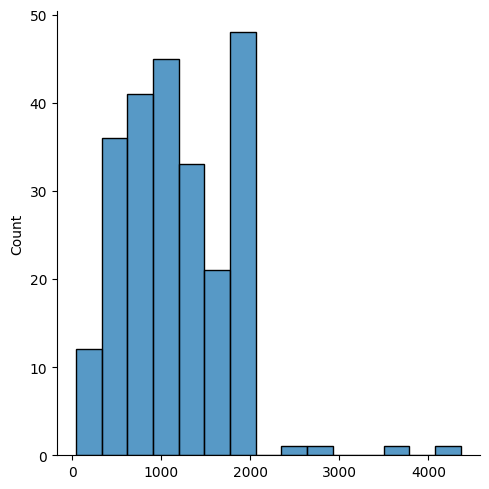

In [10]:
#Посмотрим на длину последоватеьностей
_ = sns.displot([len(sent) for sent in descriptions_train["descriptions_preproc"]])

In [11]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths: list[Path],
                 target=None,
                 transform=None,
                 tokenizer: Tokenizer = None,
                 max_length: int = 5000,
                 descriptions: list[str] = None):

        self.img_paths = img_paths
        self.target = target
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.descriptions = descriptions
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        #img =  read_image(str(img_path))
        img = Image.open(str(img_path)).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target is not None:
            label = self.target[index]
            if self.descriptions is not None:
                ids = self.tokenizer.encode(self.descriptions[index]).ids[:self.max_length]
                out = {"img": img, "label": label, "description": ids}
                return out
            else:
                out = {"img": img, "label": label}
                return out
        
        out = {"img": img}
        return out


    def __len__(self):
        return len(self.img_paths)

In [12]:
train_dataset = WbDataset(img_paths=train_paths,
                          target=ytrain,
                          transform=processor,
                          tokenizer=tokenizer,
                          descriptions=descriptions_train["descriptions_preproc"],
                         )

test_dataset = WbDataset(img_paths=test_paths,
                         target=ytest,
                         transform=processor,
                         tokenizer=tokenizer,
                         descriptions=descriptions_test["descriptions_preproc"],
                         )

In [13]:
item = train_dataset[0]

print(item.keys())
print(item["img"].shape)                        # чекаем что размеры консистентны
# print(item["label"])
# print(item["description"])
# print(tokenizer.decode(item["description"]))

dict_keys(['img', 'label', 'description'])
torch.Size([3, 224, 224])


In [14]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        tensor_dict = defaultdict(list)
        for sample in batch:
            for key, value in sample.items():
                tensor_dict[key].append(value)

        data = torch.stack(tensor_dict["img"])
        targets = torch.tensor(tensor_dict["label"])

        if self.mixes is not None:
            data, targets = self.mixes(data, targets)
        if self.transform is not None:
            data = self.transform(data)
        
        # Pad values
        out = {
            "img": data,
            "label": targets,
            "description": pad_sequence([torch.tensor(t) for t in tensor_dict["description"]], batch_first=True),
        }

        return out

In [15]:
#dataset = torch.utils.data.Subset(dataset, [i for i in range(100)])
BATCH_SIZE = 16

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [16]:
#elem = next(iter(train_loader))
#elem['img'][0].shape

# visualise_1pic(elem[0][0])

___

In [17]:
pretrain_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
pretrain_model2 = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

In [18]:
pretrain_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [19]:
pretrain_model2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
class EncoderCNN(nn.Module):
    def __init__(
        self,
        pretrain_model,
        num_classes: int,
        dropout_prob: float = 0.3,
        module_out_size: int = 1280,
        hidden_size: int = 1280 * 2,
        embed_size: int = 1024,
    ):
        super().__init__()
        
        self.module_features = pretrain_model.features
        self.module_avgpool = torch.nn.AdaptiveAvgPool2d(output_size=1)
        self.classification = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=module_out_size, out_features=num_classes),
        )
        
        self.embed = torch.nn.Sequential(
            torch.nn.Linear(in_features=module_out_size, out_features=hidden_size),
            torch.nn.Tanh(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=hidden_size, out_features=embed_size),
        )
        

#         # replace the classifier with a fully connected embedding layer
#         self.model.classifier = nn.Linear(in_features=1280, out_features=1280)
        
#         # fine tune model
#         self.set_fine_tune()
        
#         # add another fully connected layer
#         self.embed = nn.Linear(in_features=1280, out_features=embed_size)
        
#         # dropout layer
#         self.dropout = nn.Dropout(p=0.5)
        
#         # activation layers
#         self.relu = nn.ReLU()
        
        
#     def set_fine_tune(self, fine_tune=True):
#         for param in self.model.parameters():
#             param.requires_grad = fine_tune
            
    
    def forward(self, inputs):
        step_1 = self.module_features(inputs)
        step_2 = self.module_avgpool(step_1)
        step_3 = torch.flatten(step_2, 1)

        # классификация
        logits = self.classification(step_3)
        
        # эмбединги для RNN
        embeddings = self.embed(step_3)
        
        return logits, embeddings

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        
        return outputs

In [22]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [23]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(3, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1), (2, 0), (2, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

In [24]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        train_transform,
        train_mixes,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for batch in tqdm(train_loader, desc=tqdm_desc):
            data = batch["img"]
            target = batch["label"]
            
            target_mult = target
            if train_mixes is not None:
                data, target_mult = train_mixes(data, target)
            if train_transform is not None:
                data = train_transform(data)
                
            with self.accelerator.accumulate(self.model):
                logits, embeddings = self.model(data)
                loss = self.criterion(logits, target_mult)
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            for m_name, m in {
                "accuracy": partial(accuracy_score),
                "precision": partial(precision_score, average="macro", zero_division=0),
                "recall": partial(recall_score, average="macro", zero_division=0),
                "f1 macro": partial(f1_score, average="macro"),
            }.items():
                metrics[m_name] += m(
                    target.detach().cpu().numpy(), np.argmax(logits.detach().cpu().numpy(), axis=-1)
                )

            num_batches += 1

        train_loss /= num_batches
        for m_name in metrics:
            metrics[m_name] /= num_batches
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for batch in tqdm(val_loader, desc=tqdm_desc):
            data = batch["img"]
            target = batch["label"]
            
            logits, embeddings = self.model(data)
            loss = self.criterion(logits, target)

            val_loss += loss.item()
            for m_name, m in {
                "accuracy": partial(accuracy_score),
                "precision": partial(precision_score, average="macro", zero_division=0),
                "recall": partial(recall_score, average="macro", zero_division=0),
                "f1 macro": partial(f1_score, average="macro"),
            }.items():
                metrics[m_name] += m(
                    target.detach().cpu().numpy(), np.argmax(logits.detach().cpu().numpy(), axis=-1)
                )

            num_batches += 1

        val_loss /= num_batches
        for m_name in metrics:
            metrics[m_name] /= num_batches
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        train_transform=None,
        train_mixes=None,
        saving: bool = False,
        save_path: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                train_transform,
                train_mixes,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}'
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}'
            )

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value.item())
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value.item())

            if plot:
                plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if saving:
                accelerator.save_state(output_dir=save_path / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        return train_losses, val_losses, train_metrics, val_metrics

In [25]:
NUM_CLASSES=len(idx2target)

In [26]:
# Учим только последний слой
for param in pretrain_model.parameters():
#        param.requires_grad = False
       param.requires_grad = True

model = EncoderCNN(
    pretrain_model=mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2),
    num_classes=NUM_CLASSES,
)

sum(param.numel() for param in model.parameters())

8144911

In [27]:
NUM_EPOCHS = 5

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
        {"params": model.module_features.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
        {"params": model.module_avgpool.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
        {"params": model.classification.parameters(), "lr": 3e-4},
        {"params": model.embed.parameters(), "lr": 3e-4}
    ],
)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
model, optimizer = accelerator.prepare(model, optimizer)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


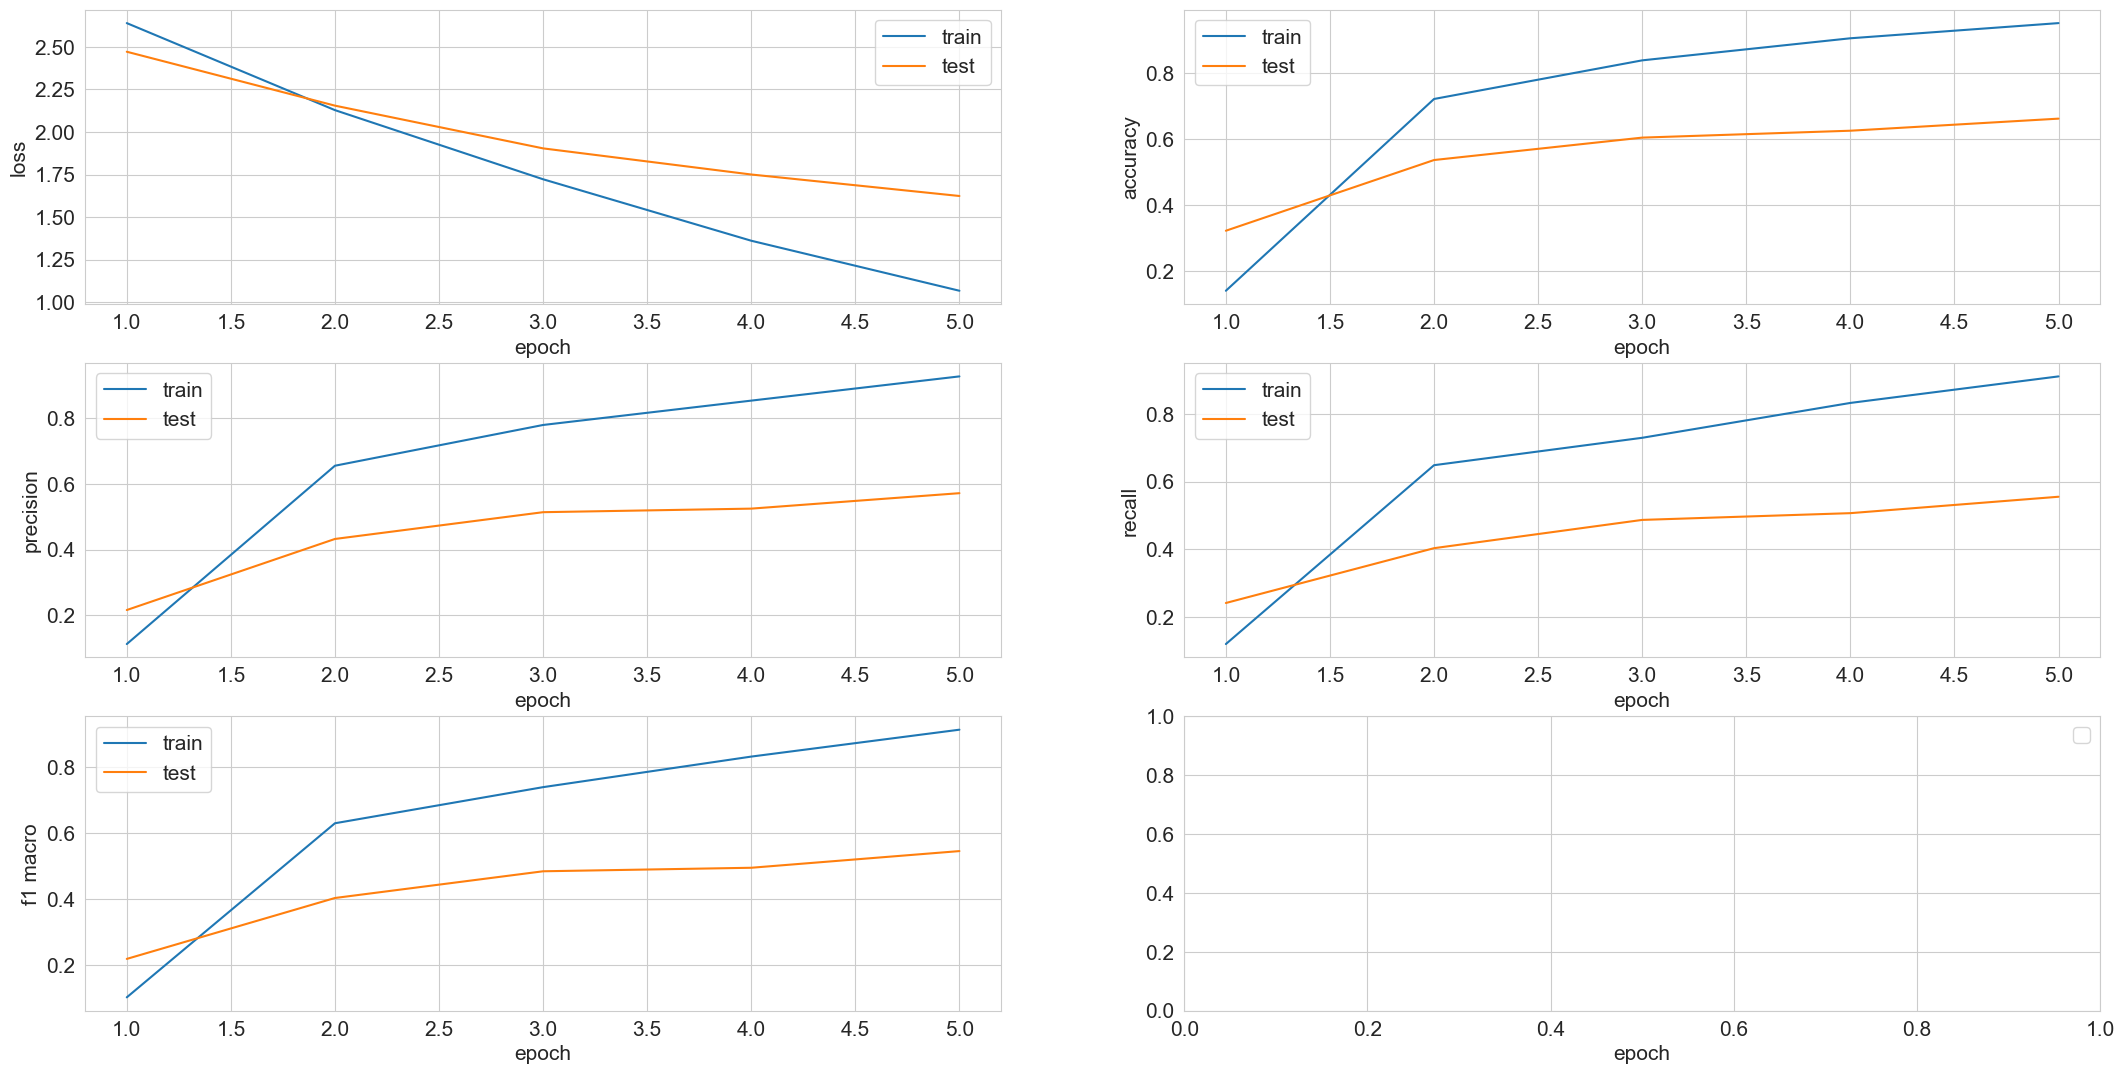

Epoch 5
val metrics
loss 1.6240852177143097
accuracy 0.6614583333333334
precision 0.5713141025641025
recall 0.5552884615384615
f1 macro 0.5460470085470085

train metrics
loss 1.0672708868980407
accuracy 0.95
precision 0.925862470862471
recall 0.9116744366744367
f1 macro 0.9142947422947425
--------------------------------------------------
0:01:08.442529


In [30]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )

a = datetime.now()
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, True)
b = datetime.now()
print(b - a)

In [31]:
for params in model.classification.parameters():
    print(params)

Parameter containing:
tensor([[ 0.0163, -0.0073, -0.0056,  ...,  0.0013,  0.0032, -0.0127],
        [ 0.0013,  0.0142, -0.0095,  ..., -0.0234,  0.0130, -0.0269],
        [-0.0100,  0.0269, -0.0202,  ..., -0.0310, -0.0168,  0.0162],
        ...,
        [ 0.0077, -0.0016, -0.0328,  ..., -0.0310, -0.0178, -0.0230],
        [-0.0074,  0.0034,  0.0354,  ..., -0.0269,  0.0092, -0.0024],
        [ 0.0011, -0.0024,  0.0078,  ...,  0.0097, -0.0183, -0.0313]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0043,  0.0007, -0.0182, -0.0249,  0.0158,  0.0082, -0.0145,  0.0045,
        -0.0054, -0.0034,  0.0144,  0.0188, -0.0259, -0.0042, -0.0202],
       device='cuda:0', requires_grad=True)


In [29]:
for params in model.classification.parameters():
    print(params)

Parameter containing:
tensor([[ 0.0112,  0.0045, -0.0009,  ...,  0.0035,  0.0105, -0.0074],
        [ 0.0044,  0.0106,  0.0013,  ..., -0.0265,  0.0159, -0.0238],
        [-0.0104,  0.0228, -0.0231,  ..., -0.0184, -0.0183,  0.0183],
        ...,
        [ 0.0060,  0.0018, -0.0236,  ..., -0.0194, -0.0200, -0.0133],
        [ 0.0057,  0.0171,  0.0275,  ..., -0.0248,  0.0085, -0.0088],
        [ 0.0087,  0.0019,  0.0151,  ...,  0.0085, -0.0111, -0.0265]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0073, -0.0035, -0.0171, -0.0233,  0.0174,  0.0096, -0.0167,  0.0029,
        -0.0081, -0.0042,  0.0127,  0.0183, -0.0230,  0.0032, -0.0205],
       device='cuda:0', requires_grad=True)


In [32]:
for params in model.embed.parameters():
    print(params)

Parameter containing:
tensor([[-2.1816e-02,  2.1646e-02,  3.5968e-03,  ...,  1.4504e-02,
          2.1626e-02, -1.4477e-02],
        [-1.1168e-02,  1.6736e-02,  2.6549e-02,  ...,  2.3776e-02,
         -1.9729e-03,  1.4674e-02],
        [-8.3078e-05,  1.6852e-02, -2.2486e-02,  ...,  1.6206e-02,
         -2.7019e-02, -2.3229e-02],
        ...,
        [-2.4680e-02, -2.0598e-02, -2.3886e-02,  ..., -1.6491e-02,
         -2.6276e-02,  1.1973e-02],
        [ 2.4608e-02, -2.5404e-02, -2.3197e-02,  ...,  1.4929e-02,
         -1.5985e-02, -1.1679e-02],
        [ 1.3618e-02, -5.8798e-03,  1.7503e-02,  ..., -5.6592e-03,
          1.7498e-02, -8.8403e-03]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0228,  0.0171, -0.0056,  ..., -0.0156,  0.0102,  0.0225],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0127,  0.0127,  0.0114,  ..., -0.0098,  0.0084,  0.0066],
        [ 0.0024,  0.0125, -0.0069,  ...,  0.0004,  0.0155,  0.0168],
        [ 0.

In [28]:
for params in model.embed.parameters():
    print(params)

Parameter containing:
tensor([[-2.1816e-02,  2.1646e-02,  3.5968e-03,  ...,  1.4504e-02,
          2.1626e-02, -1.4477e-02],
        [-1.1168e-02,  1.6736e-02,  2.6549e-02,  ...,  2.3776e-02,
         -1.9729e-03,  1.4674e-02],
        [-8.3078e-05,  1.6852e-02, -2.2486e-02,  ...,  1.6206e-02,
         -2.7019e-02, -2.3229e-02],
        ...,
        [-2.4680e-02, -2.0598e-02, -2.3886e-02,  ..., -1.6491e-02,
         -2.6276e-02,  1.1973e-02],
        [ 2.4608e-02, -2.5404e-02, -2.3197e-02,  ...,  1.4929e-02,
         -1.5985e-02, -1.1679e-02],
        [ 1.3618e-02, -5.8798e-03,  1.7503e-02,  ..., -5.6592e-03,
          1.7498e-02, -8.8403e-03]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0228,  0.0171, -0.0056,  ..., -0.0156,  0.0102,  0.0225],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0127,  0.0127,  0.0114,  ..., -0.0098,  0.0084,  0.0066],
        [ 0.0024,  0.0125, -0.0069,  ...,  0.0004,  0.0155,  0.0168],
        [ 0.